In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import resample

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['font.size'] = 11
%matplotlib inline

print("✓ Libraries imported")

✓ Libraries imported


In [50]:
class ECGPreprocessor:
    def __init__(self, fs=250):
        self.fs = fs
        self._init_filters()
        self.v_ref = 2.42
        self.adc_bits = 24
    
    def _init_filters(self):
        nyquist = self.fs / 2
        
        # Bandpass filter (0.5-40 Hz)
        low = 0.5 / nyquist
        high = 40 / nyquist
        self.b_band, self.a_band = signal.butter(4, [low, high], btype='band')
        
        # Notch filter (50 Hz)
        notch_freq = 50.0 / nyquist
        quality_factor = 30.0
        self.b_notch, self.a_notch = signal.iirnotch(notch_freq, quality_factor)
    
    def adc_to_millivolts(self, adc_signal, gain=6, offset=0):
        adc_sensitivity = (self.v_ref * 1000) / (2 ** (self.adc_bits - 1) - 1)
        return ((adc_signal - offset) * adc_sensitivity) / gain
    
    def remove_dc(self, signal_data):
        return signal_data - np.mean(signal_data)
    
    def apply_bandpass(self, signal_data):
        return signal.filtfilt(self.b_band, self.a_band, signal_data)
    
    def apply_notch(self, signal_data):
        return signal.filtfilt(self.b_notch, self.a_notch, signal_data)

print("✓ ECGPreprocessor class loaded")

✓ ECGPreprocessor class loaded


In [51]:
csv_file = "shimmer_data.csv"
df = pd.read_csv(csv_file)

timestamps = df['timestamp'].values
ecg_adc_original = df['ECG_CH1'].values
time_original = timestamps - timestamps[0]

dt = np.diff(timestamps)
fs_original = 1 / np.mean(dt)

print(f"✓ Loaded {len(df)} samples")
print(f"  Original sampling rate: {fs_original:.2f} Hz")
print(f"  Duration: {time_original[-1]:.2f} seconds")

✓ Loaded 3564 samples
  Original sampling rate: 128.09 Hz
  Duration: 27.82 seconds


In [52]:
start_time = 3
duration = 1

end_time = start_time + duration

# Validasi
if end_time > time_original[-1]:
    print(f"⚠️ WARNING: End time ({end_time}s) exceeds total duration ({time_original[-1]:.2f}s)")
    end_time = time_original[-1]
    duration = end_time - start_time
    print(f"   Adjusted: start={start_time}s, duration={duration:.2f}s")

print(f"\n📊 PLOT SETTINGS:")
print(f"  Start time: {start_time} seconds")
print(f"  End time: {end_time} seconds")
print(f"  Duration: {duration} seconds")
print(f"  Total available: {time_original[-1]:.2f} seconds")


📊 PLOT SETTINGS:
  Start time: 3 seconds
  End time: 4 seconds
  Duration: 1 seconds
  Total available: 27.82 seconds


In [53]:
fs_target = 250

# Resample
n_samples_new = int(len(ecg_adc_original) * fs_target / fs_original)
ecg_adc_resampled = resample(ecg_adc_original, n_samples_new)
time_resampled = np.linspace(0, time_original[-1], n_samples_new)


# Initialize preprocessor
preprocessor = ECGPreprocessor(fs=fs_target)

# Convert to mV
ecg_mv = preprocessor.adc_to_millivolts(ecg_adc_resampled, gain=6, offset=0)

# DC removal
ecg_dc_removed = preprocessor.remove_dc(ecg_mv)

# Bandpass filter
ecg_bandpass = preprocessor.apply_bandpass(ecg_dc_removed)

# Notch filter
ecg_notch = preprocessor.apply_notch(ecg_bandpass)

# Normalization
ecg_normalized = (ecg_notch - np.mean(ecg_notch)) / np.std(ecg_notch)

# Create mask for selected time window
mask_orig = (time_original >= start_time) & (time_original <= end_time)
mask = (time_resampled >= start_time) & (time_resampled <= end_time)

time_plot = time_resampled[mask]

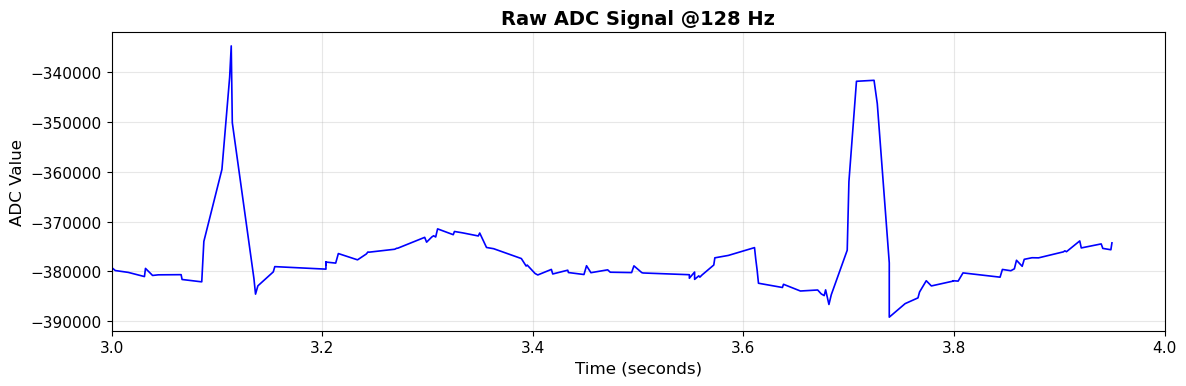

In [54]:
# ## 5. STEP 1: Raw ADC Signal (128 Hz)

# %%
plt.figure(figsize=(12, 4))
plt.plot(time_original[mask_orig], ecg_adc_original[mask_orig], 'b-', linewidth=1.2)
plt.title(f'Raw ADC Signal @128 Hz', 
          fontsize=14, fontweight='bold')
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('ADC Value', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim([start_time, end_time])
plt.tight_layout()
plt.show()

In [55]:
# # ## 6. STEP 2: Resampled to 250 Hz

# # %%
# plt.figure(figsize=(12, 4))
# plt.plot(time_plot, ecg_adc_resampled[mask], 'r-', linewidth=1.2)
# plt.title(f'Resampled Signal @250 Hz', 
#           fontsize=14, fontweight='bold')
# plt.xlabel('Time (seconds)', fontsize=12)
# plt.ylabel('ADC Value', fontsize=12)
# plt.grid(True, alpha=0.3)
# plt.xlim([start_time, end_time])
# plt.tight_layout()
# plt.show()

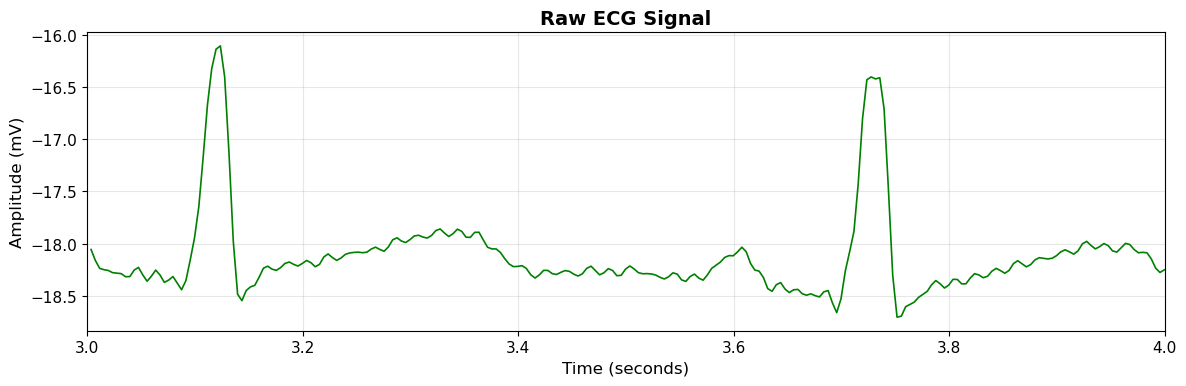

In [56]:
# ## 7. STEP 3: Converted to mV

# %%
plt.figure(figsize=(12, 4))
plt.plot(time_plot, ecg_mv[mask], 'g-', linewidth=1.2)
plt.title(f'Raw ECG Signal', 
          fontsize=14, fontweight='bold')
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Amplitude (mV)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim([start_time, end_time])
plt.tight_layout()
plt.show()

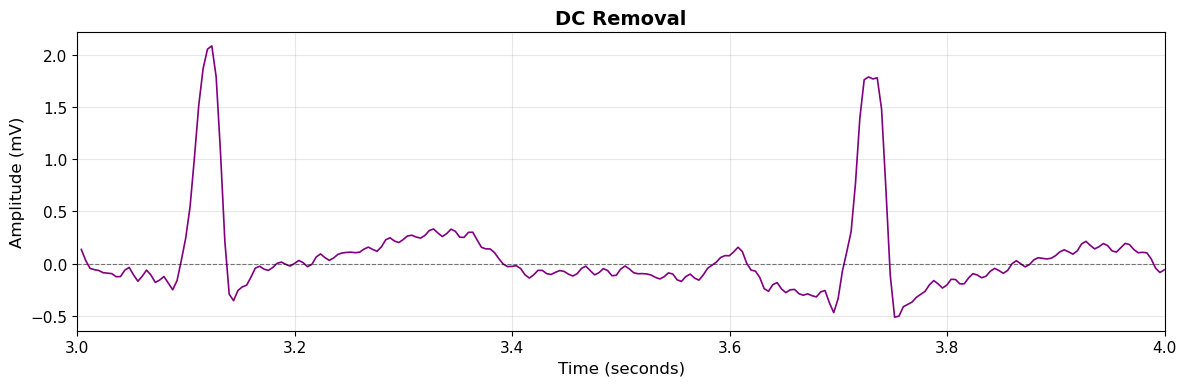

In [57]:
# ## 8. STEP 4: DC Removal

# %%
plt.figure(figsize=(12, 4))
plt.plot(time_plot, ecg_dc_removed[mask], 'purple', linewidth=1.2)
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
plt.title(f'DC Removal', 
          fontsize=14, fontweight='bold')
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Amplitude (mV)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim([start_time, end_time])
plt.tight_layout()
plt.show()

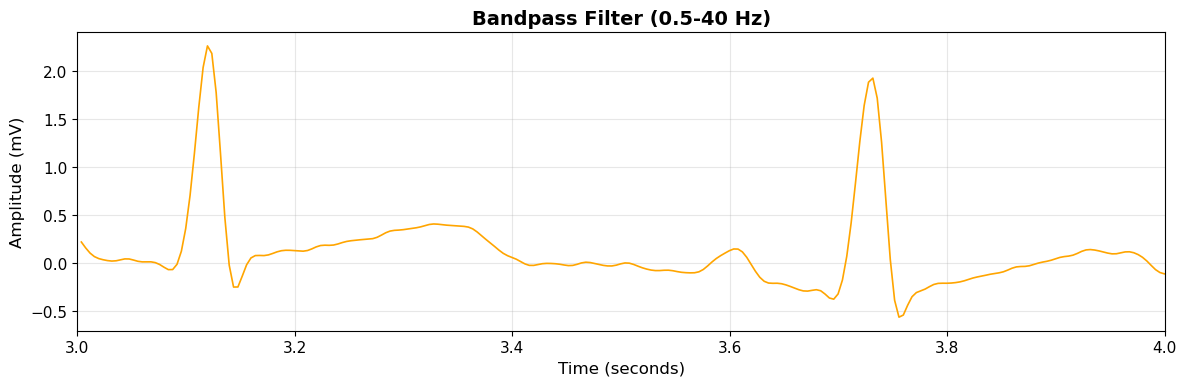

In [58]:
# ## 9. STEP 5: Bandpass Filter (0.5-40 Hz)

# %%
plt.figure(figsize=(12, 4))
plt.plot(time_plot, ecg_bandpass[mask], 'orange', linewidth=1.2)
plt.title(f'Bandpass Filter (0.5-40 Hz)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Amplitude (mV)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim([start_time, end_time])
plt.tight_layout()
plt.show()

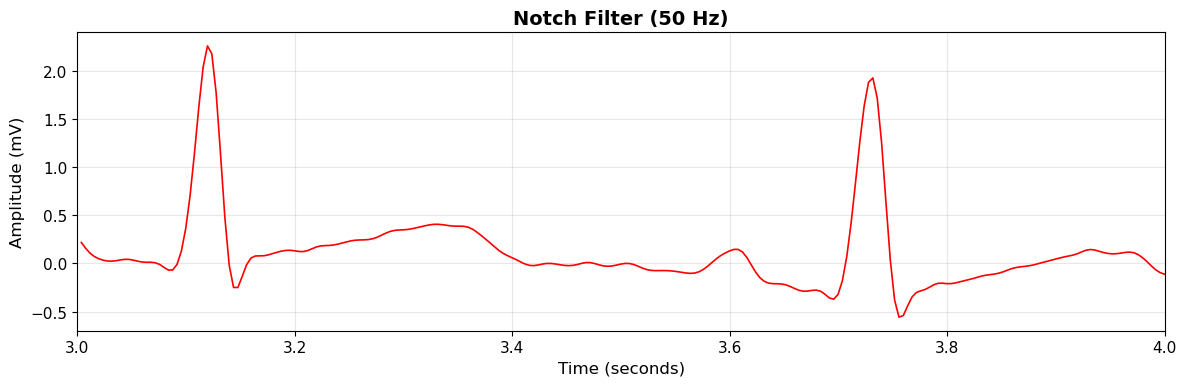

In [59]:
# ## 10. STEP 6: Notch Filter (50 Hz)

# %%
plt.figure(figsize=(12, 4))
plt.plot(time_plot, ecg_notch[mask], 'red', linewidth=1.2)
plt.title(f'Notch Filter (50 Hz)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Amplitude (mV)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim([start_time, end_time])
plt.tight_layout()
plt.show()

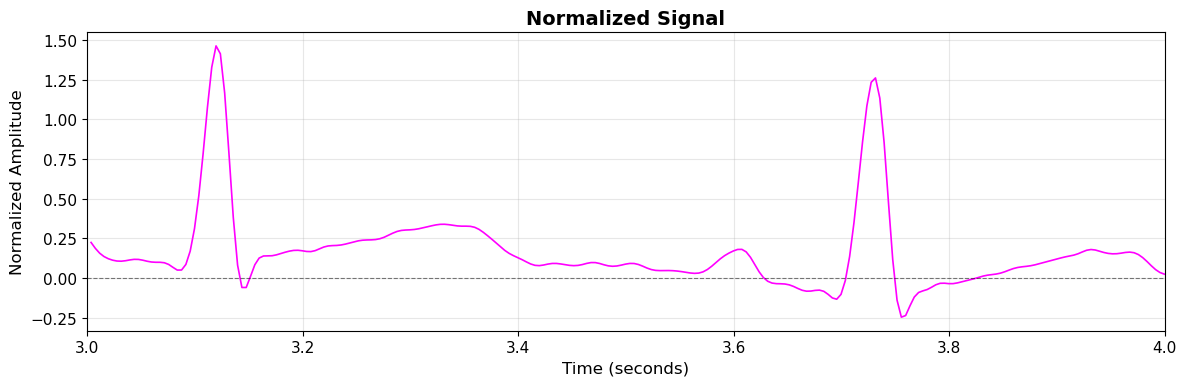

In [60]:
# ## 11. STEP 7: Z-score Normalization

# %%
plt.figure(figsize=(12, 4))
plt.plot(time_plot, ecg_normalized[mask], 'magenta', linewidth=1.2)
plt.axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
plt.title(f'Normalized Signal', 
          fontsize=14, fontweight='bold')
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Normalized Amplitude', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim([start_time, end_time])
plt.tight_layout()
plt.show()